# Diffusion Autoencoder

We do more experiments with the diffusion autoencoders (DAE), with specific focus on splitting the information into semantic and perceptual parts.

In [1]:
import jax
import jax.numpy as jnp
from jax import jit, random
from jax.tree_util import tree_map
from jax.scipy.linalg import cho_factor, cho_solve
from scipy.integrate import cumulative_trapezoid
import flax.linen as nn
import optax
import torch
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10, CIFAR100
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
from typing import Sequence, Tuple, Callable
import distrax
from scipy.integrate import solve_ivp
from functools import partial
import pandas as pd
from DiffusionModelImages import Dense, transport_to_data
from openTSNE import TSNE
from scipy.spatial.distance import cdist
import Autoencoders as ae
import TrainingUtil as tu
import UnetSA as usa
import DiffusionModelImages as dmi

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib.image")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [2]:
dataset_folder = './files'

train_MNIST = MNIST(
                      dataset_folder, 
                      train=True, 
                      transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [H, W, ch]
                        ]), 
                      download=True
                    )

test_MNIST = MNIST(
                    dataset_folder, 
                    train=False,  # Set to False to load the test dataset
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [H, W, ch]
                    ]), 
                    download=True
                )

train_CIFAR10 = CIFAR10(
                      dataset_folder, 
                      train=True, 
                      transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [32, 32, 3]
                        ]), 
                      download=True
                    )

test_CIFAR10 = CIFAR10(
                      dataset_folder, 
                      train=False, 
                      transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Lambda(lambda x: x.permute(1, 2, 0))  # Rearrange to [32, 32, 3]
                        ]), 
                      download=True
                    )

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def encode_dataset(key, dataset, encoder, batch_size=500):
    """
    Encode an entire dataset in small batches using an encoder.
    """
    data_loader = DataLoader(dataset, batch_size, shuffle=False)

    z_chunks = []
    y_chunks = []
    for xb, yb in data_loader:
        xb = jnp.asarray(xb)
        yb = jnp.asarray(yb)
        mu, logvar = encoder(xb)

        std_enc = jnp.exp(0.5 * logvar)
        key, subkey = jax.random.split(key)
        noise = jax.random.normal(subkey, std_enc.shape)

        z_batch = mu + noise * std_enc
        z_chunks.append(z_batch)
        y_chunks.append(yb)

    z_all = jnp.concatenate(z_chunks, axis=0)
    y_all = jnp.concatenate(y_chunks, axis=0)
    return z_all, y_all

Helper functions to plot and quickly test the outputs.

In [4]:
def test_vae_reconstruction(model, params, test_loader, key, num_images=10):
    """
    Run a batch of test images through the VAE and visualize original vs. reconstruction.
    """
    # Take the first batch of test images
    test_batch, _ = next(iter(test_loader))
    x_test = jnp.array(test_batch)

    # Forward pass through the VAE
    recon_x, _, _ = model.apply(params, x_test, key)

    # Visualize the results
    plt.figure(figsize=(2 * num_images, 4))
    for i in range(num_images):
        # Original
        plt.subplot(2, num_images, i + 1)
        plt.imshow(x_test[i].squeeze(), cmap='gray', vmin=0., vmax=1.)
        plt.axis('off')
        # Reconstruction
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(jnp.clip(recon_x[i].squeeze(), 0., 1.), cmap='gray', vmin=0., vmax=1.)
        plt.axis('off')
    plt.suptitle("Top: Original Images | Bottom: Reconstructions", y=1.02)
    plt.tight_layout()
    plt.show()

In [5]:
# A function to plot tSNE diagrams and a grid of distances between means of each cluster.
def plot_latent(key, test_dataset, encoder, slice_from=0, slice_upto=None, num_classes=10, batch_size=500, class_legend=True):
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False) # Use len(test_dataset)

    z_chunks, mu_chunks, y_chunks = [], [], []

    for xb, yb in test_loader:
        xb = jnp.asarray(xb)
        yb = jnp.asarray(yb)

        mu, logvar = encoder(xb)
        std_enc = jnp.exp(0.5 * logvar)
        key, subkey = random.split(key)
        noise = jax.random.normal(subkey, std_enc.shape)

        z_batch = mu + noise * std_enc

        z_chunks.append(z_batch)
        mu_chunks.append(mu)
        y_chunks.append(yb)

    z = jnp.concatenate(z_chunks, axis=0)[:, slice_from:slice_upto]
    mu = jnp.concatenate(mu_chunks, axis=0)
    y = jnp.concatenate(y_chunks, axis=0)

    if z.shape[-1] > 2:
        # If slice_right is None this goes to the very end of the array.
        z_embedded = TSNE(n_components=2, perplexity=30).fit(z)
        xlabel = "t-SNE dim 1"
        ylabel = "t-SNE dim 2"
    else:
        z_embedded = z # If latent is already 2D.
        xlabel = r"$z_1$"
        ylabel = r"$z_2$"

    # Compute mean mu for each digit class and the pairwise Euclidean distance between them.
    mu_means = jnp.stack([mu[y == label].mean(axis=0) for label in range(num_classes)])  # shape [num_classes, latent_dim]
    dist_matrix = cdist(mu_means, mu_means)  # shape [10, 10]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes = axes.flatten()
    cmap = plt.get_cmap('tab10') # tab10 is a color map with 10 distinct colors

    ax = axes[0]
    ax.scatter(z_embedded[:, 0], z_embedded[:, 1], c=y, cmap='tab10', alpha=0.6, s=10)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.7)

    # Create legend by mapping colors to digits
    uniq = np.unique(y)
    handles = [Line2D([0], [0], marker='o', linestyle='None', markeredgewidth=0,
                    markerfacecolor=cmap(int(u) % 10), markersize=6, label=str(u))
            for u in uniq]
    if class_legend:
        ax.legend(handles=handles, title='Digit',
                loc='upper center', bbox_to_anchor=(0.5, -0.1),  # center bottom
                ncol=len(uniq)//2, frameon=False, fontsize=9)

    # Plot the distance matrix
    ax = axes[1]
    im = ax.imshow(dist_matrix, cmap='viridis')
    fig.colorbar(im, label="Distance")
    ax.set_xticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
    ax.set_yticks(ticks=np.arange(10), labels=[str(i) for i in range(10)])
    ax.set_title(r"Pairwise distances between means of $z|c$")
    ax.set_xlabel("Digit label")
    ax.set_ylabel("Digit label")
    ax.grid(False)

    plt.tight_layout()
    plt.show()

In [6]:
# A function to find the Fisher ratio.
def fisher_ratio(key, test_dataset, encoder, slice_from=0, slice_upto=None, num_classes=10):
    batch_size = len(test_dataset)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False) # Use len(test_dataset)
    x, y = next(iter(test_loader))
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    mu_enc, logvar = encoder(x)
    std_enc = jnp.exp(0.5 * logvar)
    key, subkey = random.split(key)
    noise = jax.random.normal(subkey, std_enc.shape)
    z = mu_enc + noise * std_enc
    z = z[:, slice_from : slice_upto]

    mu_all = jnp.mean(z, axis=0)

    Sw, Sb = 0.0, 0.0
    for k in jnp.unique(y):
        z_k = z[y == k]
        mu_k = jnp.mean(z_k, axis=0)
        # within-class scatter: sum of squared deviations
        Sw += jnp.sum((z_k - mu_k) ** 2)
        # between-class scatter: class mean deviation times class size
        Sb += len(z_k) * jnp.sum((mu_k - mu_all) ** 2)
        
    return Sb / Sw

## Vanilla DAE

We experiment with a DAE where the latent has *not* been split into semantic and perceptual parts. Here is an example with MNIST. The same model also works with MNIST.

train iter:   0%|          | 0/50 [00:00<?, ?it/s]

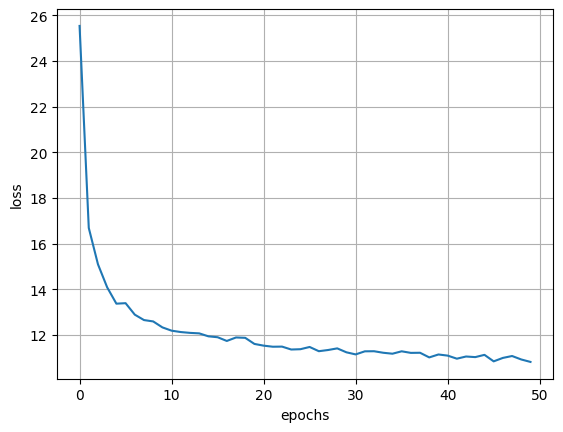

In [ ]:
latent_dim = 20
ml_key = jax.random.PRNGKey(32)
ml_key, init_key = jax.random.split(ml_key)
# enc_features = [32, 64, 128] # depth of the convolutional layers.
enc_features = [32, 64] # to match the VAE experiment.
dm_features = [512, 256]
img_shape = (28, 28, 1)

batch_size = 32

fake_input = jnp.ones((batch_size,) + img_shape)

modelDAE = ae.DiffusionAutoencoder(
                img_shape=img_shape,
                latent_dim=latent_dim,
                gamma=0.1,
                encoder_cls=ae.ConvEncoder,
                encoder_kwargs={'conv_features': enc_features},
                dmodel_kwargs={
                                'beta_min': 0.1,
                                'beta_max': 16,
                                'neural_cls': usa.UNetWithSelfAttentionAndLatent,
                                'neural_kwargs': {
                                  'ch': 256,
                                  'emb_ch': 1024,
                                  'out_ch': 1,
                                  'ch_mult': [1, 1, 1],
                                  'num_res_blocks': 1,
                                  'attn_resolutions': [7, 14],
                                  'num_heads': 1,
                                  'dropout': 0.2
                                },
                                'maxL_prefactor': False, # NOTE
                                'loss_steps': 1,
                              }
                )
paramsDAE = modelDAE.init(init_key, fake_input, ml_key)

# # In case the weights have been saved.
# paramsDAE = tu.load_model_params('files/Kelly/MNIST_DAE_USA_Unsplit_Dz=20')

paramsDAE, losses = ae.train_vae(key=ml_key,
                            model=modelDAE,
                            params=paramsDAE,
                            learning_rate=0.0002, # 1e-4 for small U-net
                            epochs=50,
                            train_dataset=train_MNIST,
                            batch_size=batch_size,
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

# tu.save_model_params(paramsDAE, 'files/Kelly/MNIST_DAE_USA_Unsplit_Dz=20')

First we run the standard tests to see if the autoencoder reconstructs the data.

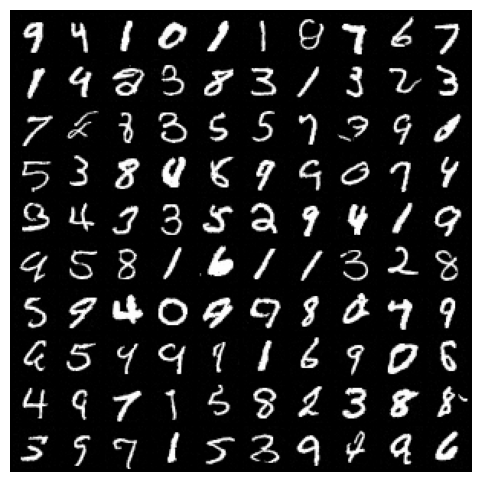

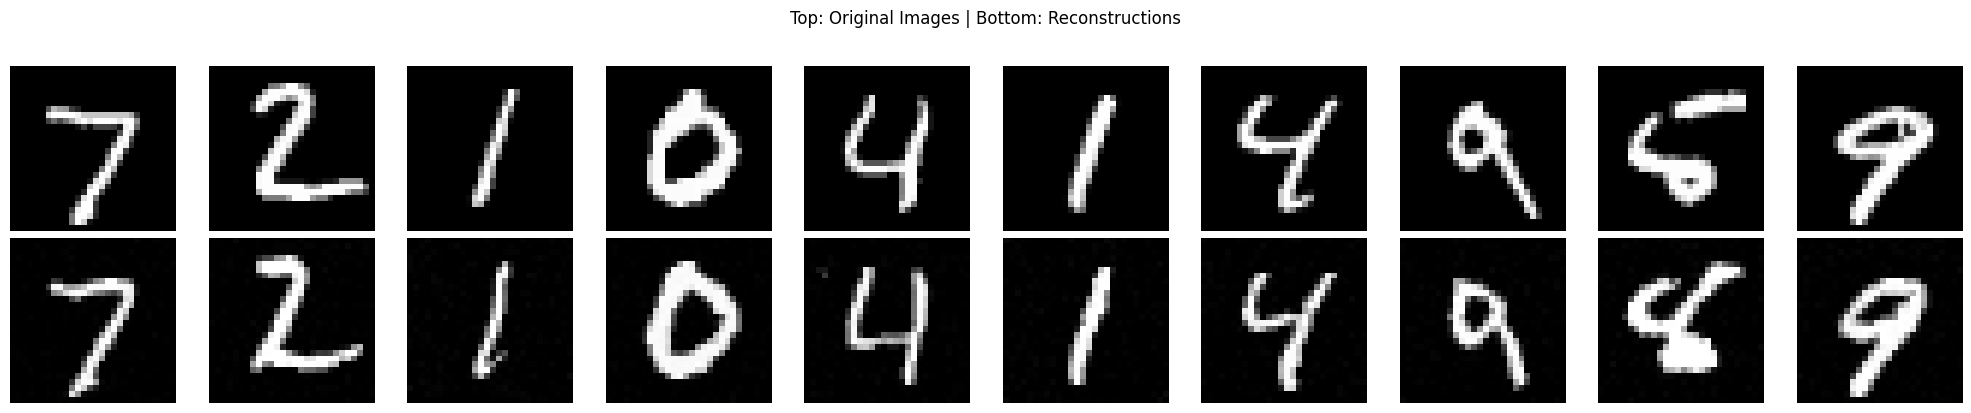

In [18]:
num_samples = 100
key = jax.random.PRNGKey(5)
key, subkey = random.split(key)
z = random.normal(subkey, (num_samples, latent_dim))
key, subkey = random.split(key)
samples = modelDAE.apply(paramsDAE, z, subkey, method=modelDAE.decode)

samples_vis = jnp.transpose(samples, (0, 3, 1, 2))
sample_grid = make_grid(torch.tensor(np.asarray(samples_vis)), nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu().clamp(0., 1.), vmin=0., vmax=1.)
plt.show()

batch_size = 10
test_loader = DataLoader(test_MNIST, batch_size, shuffle=False)

key, subkey = random.split(key)
test_vae_reconstruction(modelDAE, paramsDAE, test_loader, key, num_images=batch_size)

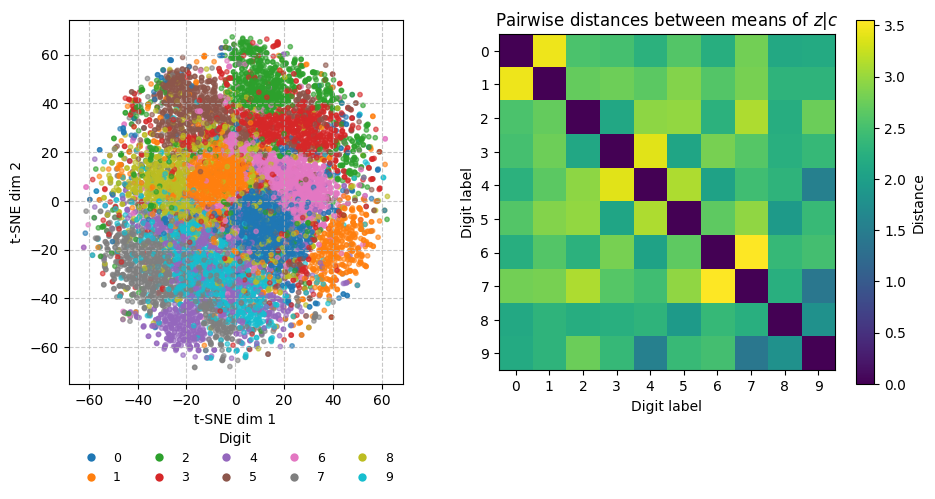

Fisher ratio is 0.16607770323753357


In [9]:
key = jax.random.PRNGKey(29)
encoder = lambda x : modelDAE.apply(paramsDAE, x, method=modelDAE.encode)

plot_latent(key, test_MNIST, encoder)
fr = fisher_ratio(key, test_MNIST, encoder)
print(f'Fisher ratio is {fr}')

We can train a smaller diffusion model to compute $I(Z,Y)$.

In [15]:
# Binds parameters with the model so params are routed to method of the class and its children.
boundDAE = modelDAE.bind(paramsDAE)
ent_key = jax.random.PRNGKey(31) # Use a smaller batch for entropy calculation.
ent_key, subkey = random.split(ent_key)
z_test, y_test = encode_dataset(subkey, test_MNIST, boundDAE.encode)
ent_key, subkey = random.split(ent_key)
z_train, y_train = encode_dataset(subkey, train_MNIST, boundDAE.encode)

train iter:   0%|          | 0/100 [00:00<?, ?it/s]

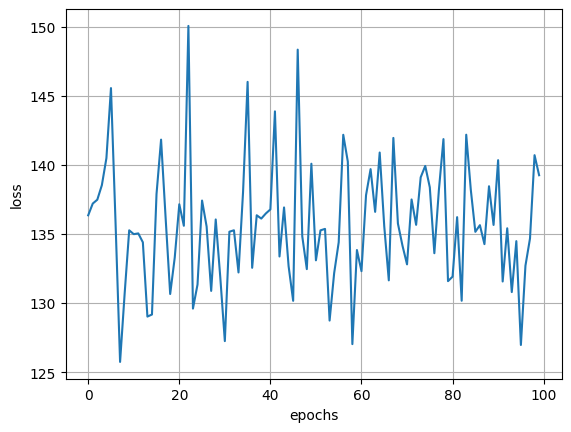

In [16]:
zy_dataset = ae.GaussianMixtureDataset(np.array(z_train), np.array(y_train))

# ml_key = jax.random.PRNGKey(47)
ml_key, init_key = jax.random.split(ml_key)
dm_features = [512, 256]

fake_z = jnp.ones((batch_size, latent_dim))
fake_y = jnp.ones((batch_size, 1), dtype=jnp.int32)
fake_time = jnp.ones((batch_size,))

dmodel_ZY = ae.DiffusionLatent(features=dm_features,
                            mapping_size=256,
                            num_labels=10,
                            num_dimensions=latent_dim,
                            beta_min=0.1,
                            beta_max=16,
                            z_embed=False,
                            maxL_prefactor=True, # Note.
                            p_drop=0.1,
                            loss_steps=10)
params_ZY = dmodel_ZY.init(init_key, fake_z, fake_y, fake_time)

params_ZY, losses = ae.train_vae(key=ml_key,
                            model=dmodel_ZY,
                            params=params_ZY,
                            learning_rate=0.001,
                            epochs=100,
                            train_dataset=zy_dataset,
                            batch_size=batch_size
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

In [17]:
mi_batch_size = 10000

ent_key, subkey = random.split(ent_key)
dmodel_ZY.apply(params_ZY, z_test[:mi_batch_size], y_test[:mi_batch_size], subkey, method=dmodel_ZY.mutual_info)

Array(2.6929362, dtype=float32)

## Information Heirarchy

We experiment with the diffusion autoencoder with separate semantic and perceptual components.

train iter:   0%|          | 0/50 [00:00<?, ?it/s]

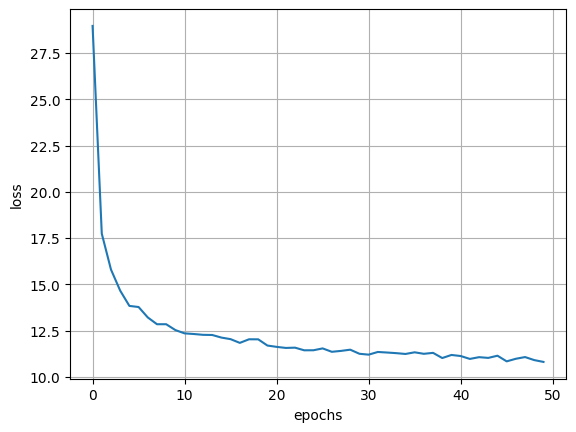

In [11]:
ml_key = jax.random.PRNGKey(32)
ml_key, init_key = jax.random.split(ml_key)
enc_sem_features = [32, 64, 128] # depth of the convolutional layers.
enc_per_features = [32, 64] # perceptive encoder produces a larger field of view.
dm_features = [512, 256]
img_shape = (28, 28, 1)

batch_size = 32
sem_dim = 20
split_time = 0.9

fake_input = jnp.ones((batch_size,) + img_shape)

modelDAE_sep = ae.DiffusionAutoencoderHeirarchical(
                img_shape=img_shape,
                latent_sem_dim=sem_dim,
                latent_per_dim=sem_dim,
                gamma=0.1,
                encoder_sem_cls=ae.ConvEncoder,
                encoder_sem_kwargs={'conv_features': enc_sem_features},
                encoder_per_cls=ae.ConvEncoder,
                encoder_per_kwargs={'conv_features': enc_per_features},
                dmodel_cls=ae.DiffusionDecoderImagesLadder,
                dmodel_kwargs={
                                'beta_min': 0.1,
                                'beta_max': 16,
                                'neural_cls': usa.UNetWithSelfAttentionAndLatent,
                                'neural_kwargs': {
                                  'ch': 256,
                                  'emb_ch': 1024,
                                  'out_ch': 1,
                                  'ch_mult': [1, 1, 1],
                                  'num_res_blocks': 1,
                                  'attn_resolutions': [7, 14],
                                  'num_heads': 1,
                                  'dropout': 0.2
                                },
                                'maxL_prefactor': False, # NOTE
                                'loss_steps': 1,
                                'split_time': split_time,
                                'split_dim': sem_dim
                              },
                )
paramsDAE_sep = modelDAE_sep.init(init_key, fake_input, ml_key)

# # In case the weights have been saved.
# paramsDAE_sep = tu.load_model_params(f'../files/Kelly/batch/MNIST_DAE_USA_Split_Dsem={sem_dim}_ts={split_time}')

paramsDAE_sep, losses = ae.train_vae(key=ml_key,
                            model=modelDAE_sep,
                            params=paramsDAE_sep,
                            learning_rate=0.0001,
                            epochs=50,
                            train_dataset=train_MNIST,
                            batch_size=batch_size,
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

# tu.save_model_params(paramsDAE_sep, f'../files/Kelly/batch/MNIST_DAE_USA_Split_Dsem={sem_dim}_ts={split_time}')

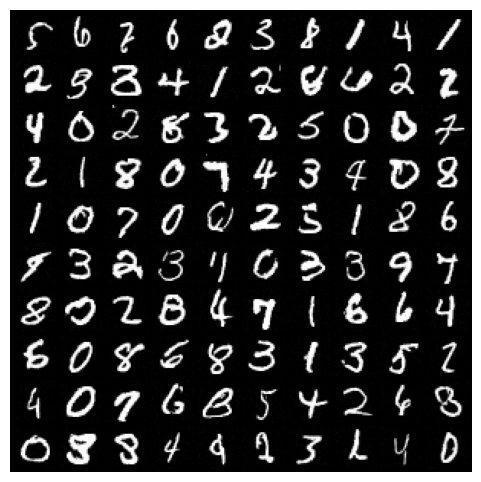

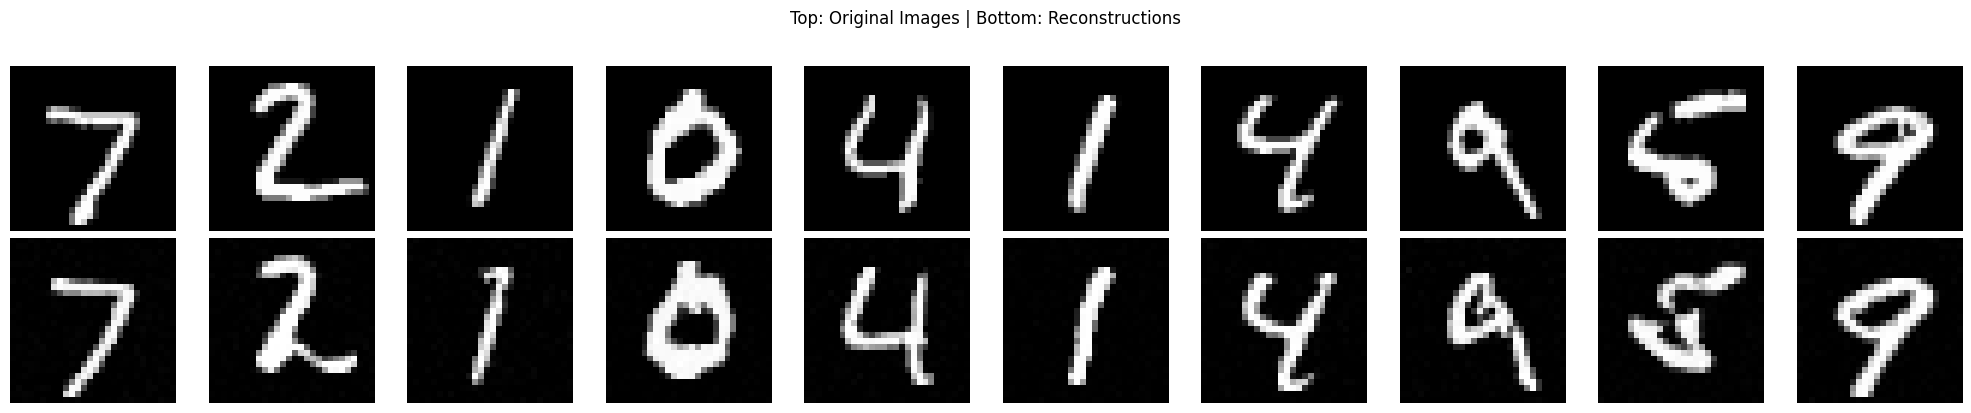

In [ ]:
num_samples = 100
key = jax.random.PRNGKey(34)
key, subkey = random.split(key)
z = random.normal(subkey, (num_samples, modelDAE_sep.latent_sem_dim + modelDAE_sep.latent_per_dim))
key, subkey = random.split(key)
samples = modelDAE_sep.apply(paramsDAE_sep, z, subkey, method=modelDAE_sep.decode)

samples_vis = jnp.transpose(samples, (0, 3, 1, 2))
sample_grid = make_grid(torch.tensor(np.asarray(samples_vis)), nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu().clamp(0., 1.), vmin=0., vmax=1.)
plt.show()

batch_size = 10
test_loader = DataLoader(test_MNIST, batch_size, shuffle=False)

key, subkey = random.split(key)
test_vae_reconstruction(modelDAE_sep, paramsDAE_sep, test_loader, key, num_images=batch_size)

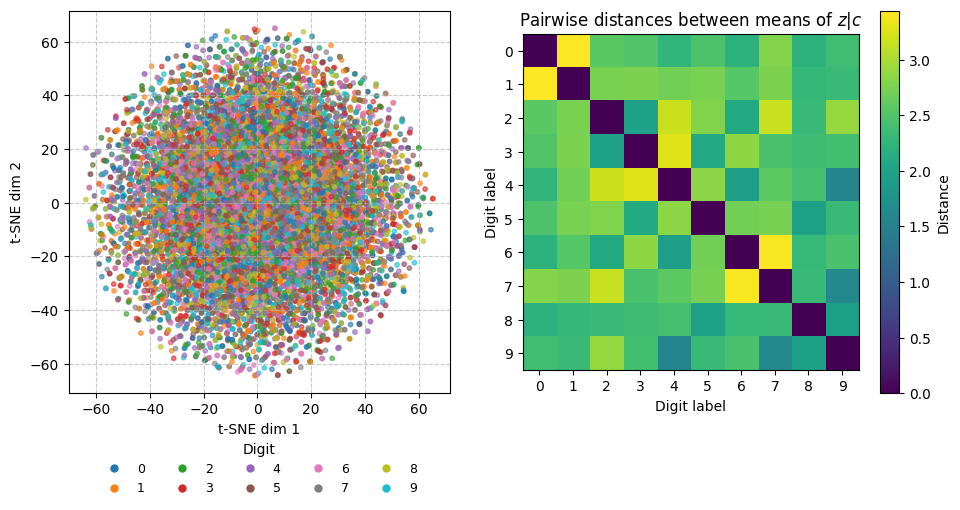

Fisher ratio for semantic latent is 0.0010375845013186336


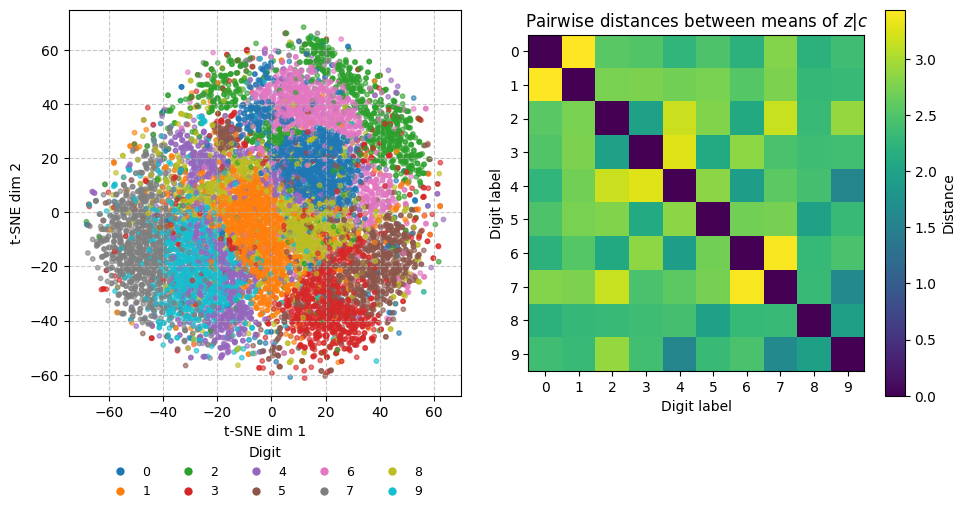

Fisher ratio for perceptual latent is 0.16719399392604828


In [13]:
key = jax.random.PRNGKey(29)
encoder = lambda x : modelDAE_sep.apply(paramsDAE_sep, x, method=modelDAE_sep.encode)
sem_dim = modelDAE_sep.latent_sem_dim

plot_latent(key, test_MNIST, encoder, slice_upto=sem_dim) # z_sem
fr_sem = fisher_ratio(key, test_MNIST, encoder, slice_upto=sem_dim)
print(f'Fisher ratio for semantic latent is {fr_sem}')

plot_latent(key, test_MNIST, encoder, slice_from=sem_dim) # z_per
fr_per = fisher_ratio(key, test_MNIST, encoder, slice_from=sem_dim)
print(f'Fisher ratio for perceptual latent is {fr_per}')

In [18]:
# Binds parameters with the model so params are routed to method of the class and its children.
boundDAE_sep = modelDAE_sep.bind(paramsDAE_sep)
ent_key = jax.random.PRNGKey(31) # Use a smaller batch for entropy calculation.
ent_key, subkey = random.split(ent_key)
z_test, y_test = encode_dataset(subkey, test_MNIST, boundDAE_sep.encode)
ent_key, subkey = random.split(ent_key)
z_train, y_train = encode_dataset(subkey, train_MNIST, boundDAE_sep.encode)

train iter:   0%|          | 0/100 [00:00<?, ?it/s]

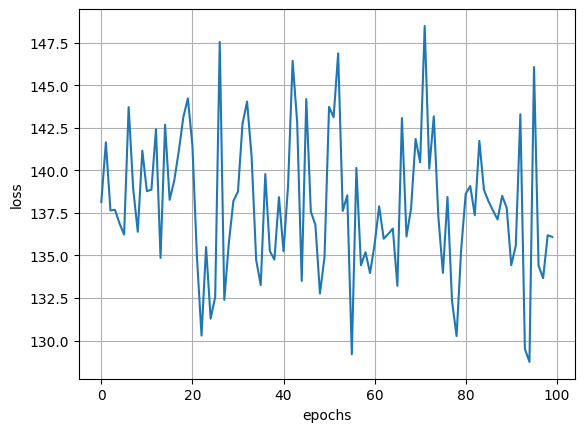

In [19]:
# Use the training dataset to generate the latents to train the ZY MI estimator.

# Only include the semantic components.
zy_dataset = ae.GaussianMixtureDataset(np.array(z_train[:, :sem_dim]), np.array(y_train))

# ml_key = jax.random.PRNGKey(47)
ml_key, init_key = jax.random.split(ml_key)
dm_features = [512, 256]
batch_size = 32

fake_z = jnp.ones((batch_size, sem_dim))
fake_y = jnp.ones((batch_size, 1), dtype=jnp.int32)
fake_time = jnp.ones((batch_size,))

dmodel_ZY_sem = ae.DiffusionLatent(features=dm_features,
                            mapping_size=256,
                            num_labels=10,
                            num_dimensions=sem_dim,
                            beta_min=0.1,
                            beta_max=16,
                            z_embed=False,
                            maxL_prefactor=True, # Note.
                            p_drop=0.1,
                            loss_steps=10)
params_ZY_sem = dmodel_ZY_sem.init(init_key, fake_z, fake_y, fake_time)

params_ZY_sem, losses = ae.train_vae(key=ml_key,
                            model=dmodel_ZY_sem,
                            params=params_ZY_sem,
                            learning_rate=0.001,
                            epochs=100,
                            train_dataset=zy_dataset,
                            batch_size=batch_size
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

train iter:   0%|          | 0/100 [00:00<?, ?it/s]

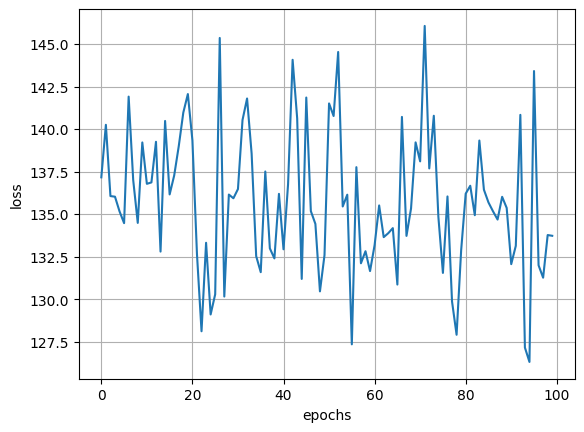

In [20]:
# Use the training dataset to generate the latents to train the ZY MI estimator.

# Only include the *perceptual* components.
zy_dataset = ae.GaussianMixtureDataset(np.array(z_train[:, sem_dim:]), np.array(y_train))

# ml_key = jax.random.PRNGKey(47)
ml_key, init_key = jax.random.split(ml_key)
dm_features = [512, 256]
batch_size = 32

fake_z = jnp.ones((batch_size, sem_dim))
fake_y = jnp.ones((batch_size, 1), dtype=jnp.int32)
fake_time = jnp.ones((batch_size,))

dmodel_ZY_per = ae.DiffusionLatent(features=dm_features,
                            mapping_size=256,
                            num_labels=10,
                            num_dimensions=sem_dim,
                            beta_min=0.1,
                            beta_max=16,
                            z_embed=False,
                            maxL_prefactor=True, # Note.
                            p_drop=0.1,
                            loss_steps=10)
params_ZY_per = dmodel_ZY_per.init(init_key, fake_z, fake_y, fake_time)

params_ZY_per, losses = ae.train_vae(key=ml_key,
                            model=dmodel_ZY_per,
                            params=params_ZY_per,
                            learning_rate=0.001,
                            epochs=100,
                            train_dataset=zy_dataset,
                            batch_size=batch_size
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

In [21]:
mi_batch_size = 1000

ent_key, subkey = random.split(ent_key)
mi_sem_y = dmodel_ZY_sem.apply(params_ZY_sem, z_test[:mi_batch_size, :sem_dim], y_test[:mi_batch_size], subkey, method=dmodel_ZY_sem.mutual_info)

ent_key, subkey = random.split(ent_key)
mi_per_y = dmodel_ZY_per.apply(params_ZY_per, z_test[:mi_batch_size, sem_dim:], y_test[:mi_batch_size], subkey, method=dmodel_ZY_per.mutual_info)

print(f'I(Z_sem; Y) = {mi_sem_y}')
print(f'I(Z_per; Y) = {mi_per_y}')

I(Z_sem; Y) = 0.002008083276450634
I(Z_per; Y) = 2.7306599617004395


## CIFAR-10

Similar set of experiments with the CIFAR-10 dataset.

train iter:   0%|          | 0/50 [00:00<?, ?it/s]

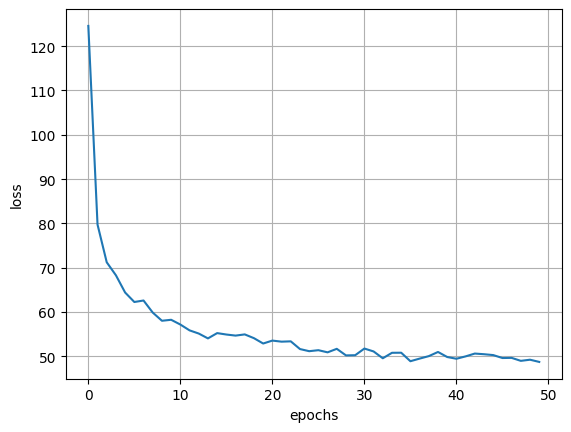

In [22]:
latent_dim = 60
ml_key = jax.random.PRNGKey(32)
ml_key, init_key = jax.random.split(ml_key)
enc_features = [32, 64, 128] # depth of the convolutional layers.
img_shape = (32, 32, 3)

batch_size = 32

fake_input = jnp.ones((batch_size,) + img_shape)

modelDAE = ae.DiffusionAutoencoder(
                img_shape=img_shape,
                latent_dim=latent_dim,
                gamma=0.01,
                encoder_cls=ae.ConvEncoder,
                encoder_kwargs={'conv_features': enc_features},
                dmodel_kwargs={
                                'beta_min': 0.1,
                                'beta_max': 16,
                                'neural_cls': usa.UNetWithSelfAttentionAndLatent,
                                'neural_kwargs': {
                                  'ch': 256,
                                  'emb_ch': 1024,
                                  'out_ch': 3,
                                  'ch_mult': [1, 1, 1],
                                  'num_res_blocks': 2,
                                  'attn_resolutions': [8, 16],
                                  'num_heads': 1,
                                  'dropout': 0.2
                                },
                                'maxL_prefactor': False, # NOTE
                                'loss_steps': 1,
                              }
                )
paramsDAE = modelDAE.init(init_key, fake_input, ml_key)

# # In case the weights have been saved.
# paramsDAE = tu.load_model_params('files/Kelly/CIFAR10_DAE_Unsplit_Dz=60_epochs=50')

paramsDAE, losses = ae.train_vae(key=ml_key,
                            model=modelDAE,
                            params=paramsDAE,
                            learning_rate=0.0002, # NOTE: Higher learning rate.
                            epochs=50,
                            train_dataset=train_CIFAR10,
                            batch_size=batch_size,
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

# tu.save_model_params(paramsDAE, 'files/Kelly/CIFAR10_DAE_Unsplit_Dz=60_epochs=50')

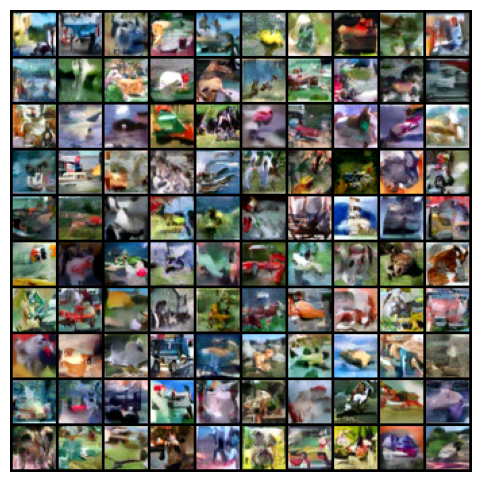

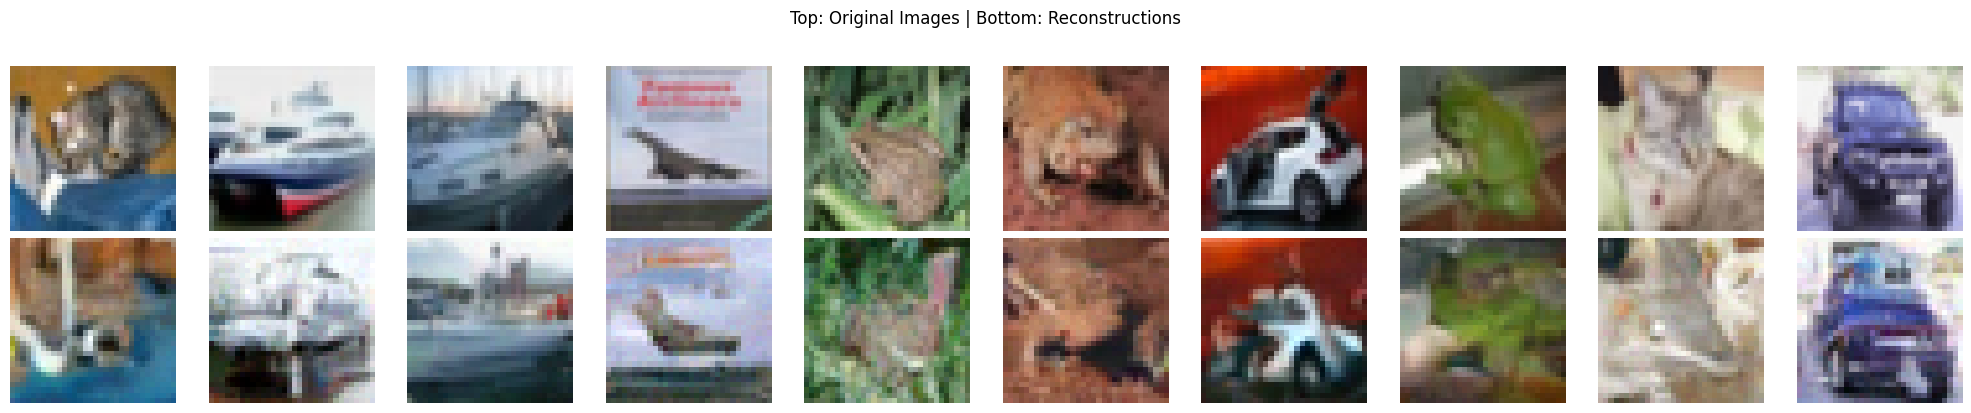

In [27]:
num_samples = 100
key = jax.random.PRNGKey(32)
key, subkey = random.split(key)
z = random.normal(subkey, (num_samples, latent_dim))
key, subkey = random.split(key)
samples = modelDAE.apply(paramsDAE, z, subkey, method=modelDAE.decode)

samples_vis = jnp.transpose(samples, (0, 3, 1, 2))
sample_grid = make_grid(torch.tensor(np.asarray(samples_vis)), nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu().clamp(0., 1.), vmin=0., vmax=1.)
plt.show()

batch_size = 10
test_loader = DataLoader(test_CIFAR10, batch_size, shuffle=False)

key, subkey = random.split(key)
test_vae_reconstruction(modelDAE, paramsDAE, test_loader, key, num_images=batch_size)

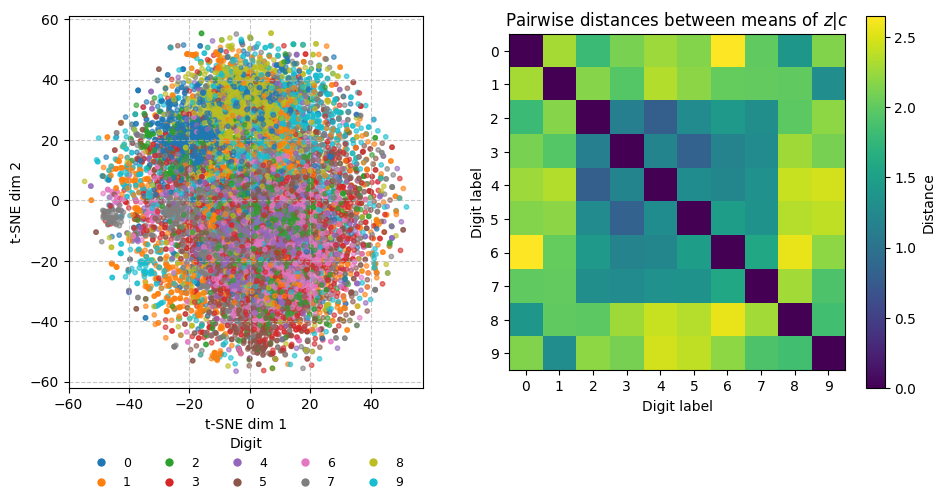

Fisher ratio is 0.037074554711580276


In [28]:
key = jax.random.PRNGKey(29)
encoder = lambda x : modelDAE.apply(paramsDAE, x, method=modelDAE.encode)

plot_latent(key, test_CIFAR10, encoder)
fr = fisher_ratio(key, test_CIFAR10, encoder)
print(f'Fisher ratio is {fr}')

In [30]:
# Binds parameters with the model so params are routed to method of the class and its children.
boundDAE = modelDAE.bind(paramsDAE)
ent_key = jax.random.PRNGKey(31) # Use a smaller batch for entropy calculation.
ent_key, subkey = random.split(ent_key)
z_test, y_test = encode_dataset(ent_key, test_CIFAR10, boundDAE.encode)
ent_key, subkey = random.split(ent_key)
z_train, y_train = encode_dataset(subkey, test_CIFAR10, boundDAE.encode)

train iter:   0%|          | 0/100 [00:00<?, ?it/s]

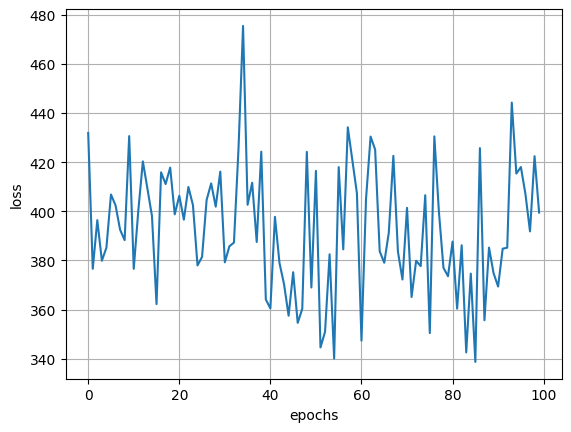

In [31]:
zy_dataset = ae.GaussianMixtureDataset(np.array(z_train), np.array(y_train))

# ml_key = jax.random.PRNGKey(47)
ml_key, init_key = jax.random.split(ml_key)
dm_features = [512, 256]

fake_z = jnp.ones((batch_size, latent_dim))
fake_y = jnp.ones((batch_size, 1), dtype=jnp.int32)
fake_time = jnp.ones((batch_size,))

dmodel_ZY = ae.DiffusionLatent(features=dm_features,
                            mapping_size=256,
                            num_labels=10,
                            num_dimensions=latent_dim,
                            beta_min=0.1,
                            beta_max=16,
                            z_embed=False,
                            maxL_prefactor=True, # Note.
                            p_drop=0.1,
                            loss_steps=10)
params_ZY = dmodel_ZY.init(init_key, fake_z, fake_y, fake_time)

params_ZY, losses = ae.train_vae(key=ml_key,
                            model=dmodel_ZY,
                            params=params_ZY,
                            learning_rate=0.001,
                            epochs=100,
                            train_dataset=zy_dataset,
                            batch_size=batch_size
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

In [32]:
mi_batch_size = 10000

ent_key, subkey = random.split(ent_key)
dmodel_ZY.apply(params_ZY, z_test[:mi_batch_size], y_test[:mi_batch_size], subkey, method=dmodel_ZY.mutual_info)

Array(2.1546745, dtype=float32)

### Split latents

train iter:   0%|          | 0/50 [00:00<?, ?it/s]

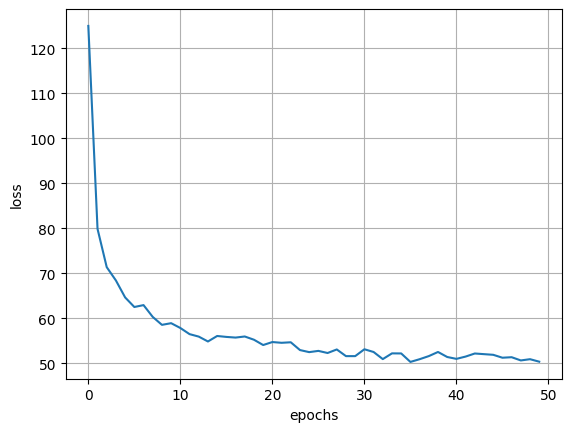

In [8]:
ml_key = jax.random.PRNGKey(32)
ml_key, init_key = jax.random.split(ml_key)
enc_sem_features = [32, 64, 128] # depth of the convolutional layers.
enc_per_features = [32, 64] # perceptive encoder produces a larger field of view.
img_shape = (32, 32, 3)

batch_size = 32
sem_dim = 60
split_time = 0.1

fake_input = jnp.ones((batch_size,) + img_shape)

modelDAE_sep = ae.DiffusionAutoencoderHeirarchical(
                img_shape=img_shape,
                latent_sem_dim=sem_dim,
                latent_per_dim=sem_dim,
                gamma=0.01,
                encoder_sem_cls=ae.ConvEncoder,
                encoder_sem_kwargs={'conv_features': enc_sem_features},
                encoder_per_cls=ae.ConvEncoder,
                encoder_per_kwargs={'conv_features': enc_per_features},
                dmodel_cls=ae.DiffusionDecoderImagesLadder,
                dmodel_kwargs={
                                'beta_min': 0.1,
                                'beta_max': 16,
                                'neural_cls': usa.UNetWithSelfAttentionAndLatent,
                                'neural_kwargs': {
                                  'ch': 256,
                                  'emb_ch': 1024,
                                  'out_ch': 3,
                                  'ch_mult': [1, 1, 1],
                                  'num_res_blocks': 2,
                                  'attn_resolutions': [8, 16],
                                  'num_heads': 1,
                                  'dropout': 0.2
                                },
                                'maxL_prefactor': False, # NOTE
                                'loss_steps': 1,
                                'split_time': split_time,
                                'split_dim': sem_dim
                              },
                )
paramsDAE_sep = modelDAE_sep.init(init_key, fake_input, ml_key)

# # In case the weights have been saved.
# paramsDAE_sep = tu.load_model_params('files/Kelly/CIFAR_DAE_Split_Dsem=60_epochs=50_ts=0.1')

paramsDAE_sep, losses = ae.train_vae(key=ml_key,
                            model=modelDAE_sep,
                            params=paramsDAE_sep,
                            learning_rate=0.0002,
                            epochs=50,
                            train_dataset=train_CIFAR10,
                            batch_size=batch_size,
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

# tu.save_model_params(paramsDAE_sep, f'files/Kelly/batch/CIFAR_DAE_Split_Dsem=60_epochs=50_ts={split_time}')

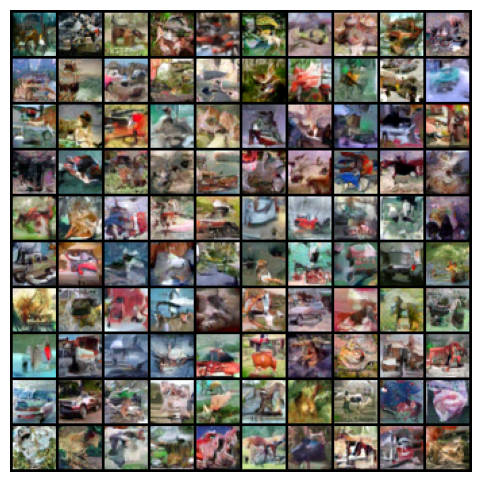

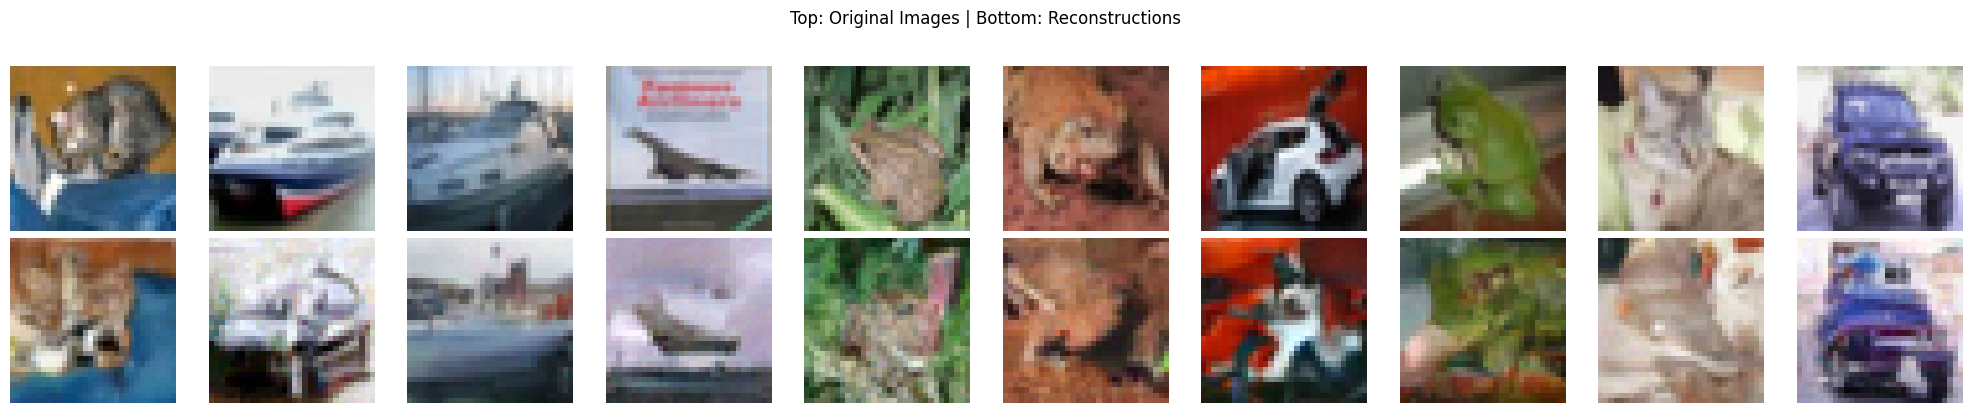

In [10]:
num_samples = 100
key = jax.random.PRNGKey(32)
key, subkey = random.split(key)
z = random.normal(subkey, (num_samples, modelDAE_sep.latent_sem_dim + modelDAE_sep.latent_per_dim))
key, subkey = random.split(key)
samples = modelDAE_sep.apply(paramsDAE_sep, z, subkey, method=modelDAE_sep.decode)

samples_vis = jnp.transpose(samples, (0, 3, 1, 2))
sample_grid = make_grid(torch.tensor(np.asarray(samples_vis)), nrow=int(np.sqrt(num_samples)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu().clamp(0., 1.), vmin=0., vmax=1.)
plt.show()

batch_size = 10
test_loader = DataLoader(test_CIFAR10, batch_size, shuffle=False)

key, subkey = random.split(key)
test_vae_reconstruction(modelDAE_sep, paramsDAE_sep, test_loader, key, num_images=batch_size)

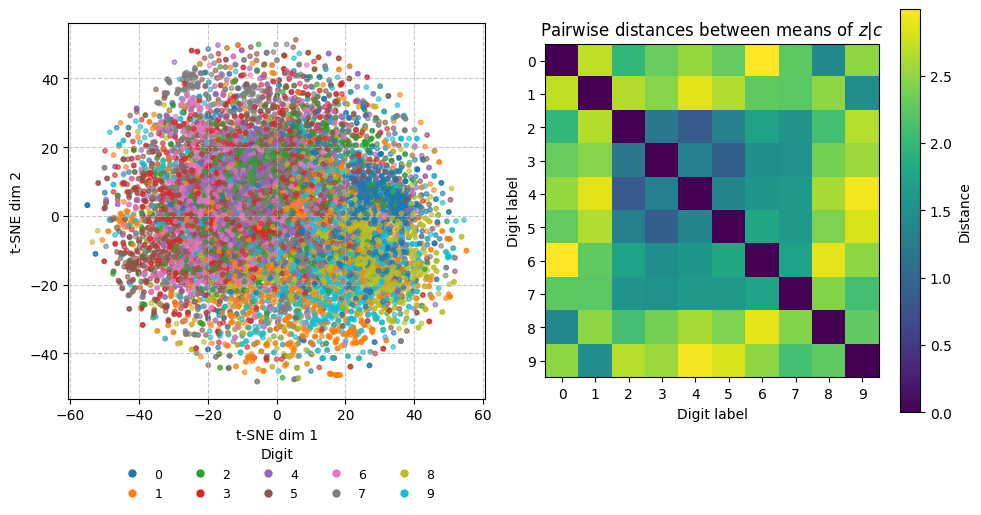

Fisher ratio for semantic latent is 0.03146315738558769


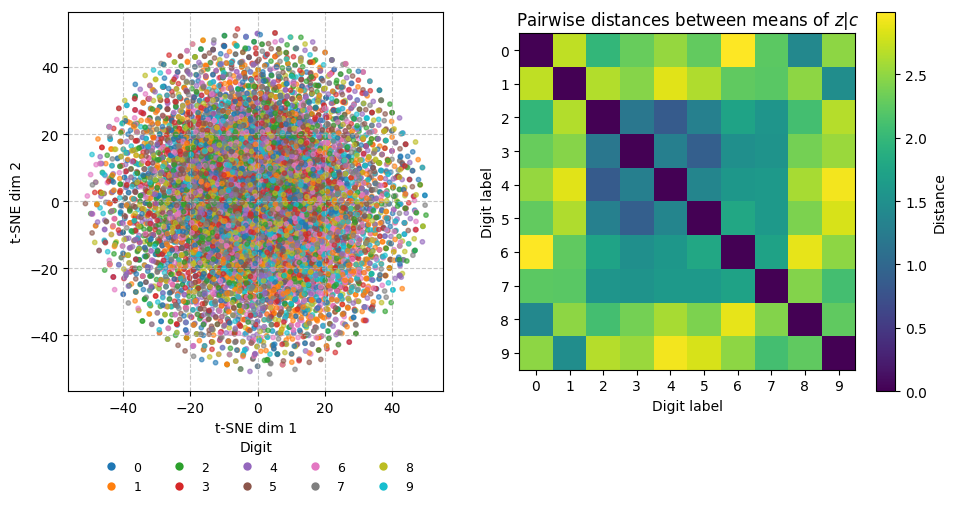

Fisher ratio for perceptual latent is 0.006479782052338123


In [11]:
key = jax.random.PRNGKey(29)
encoder = lambda x : modelDAE_sep.apply(paramsDAE_sep, x, method=modelDAE_sep.encode)
sem_dim = modelDAE_sep.latent_sem_dim

plot_latent(key, test_CIFAR10, encoder, slice_upto=sem_dim) # z_sem
fr_sem = fisher_ratio(key, test_CIFAR10, encoder, slice_upto=sem_dim)
print(f'Fisher ratio for semantic latent is {fr_sem}')

plot_latent(key, test_CIFAR10, encoder, slice_from=sem_dim) # z_per
fr_per = fisher_ratio(key, test_CIFAR10, encoder, slice_from=sem_dim)
print(f'Fisher ratio for perceptual latent is {fr_per}')

In [12]:
# Binds parameters with the model so params are routed to method of the class and its children.
boundDAE_sep = modelDAE_sep.bind(paramsDAE_sep)
ent_key = jax.random.PRNGKey(31) # Use a smaller batch for entropy calculation.
ent_key, subkey = random.split(ent_key)
z_test, y_test = encode_dataset(subkey, test_CIFAR10, boundDAE_sep.encode)
ent_key, subkey = random.split(ent_key)
z_train, y_train = encode_dataset(subkey, train_CIFAR10, boundDAE_sep.encode)

train iter:   0%|          | 0/100 [00:00<?, ?it/s]

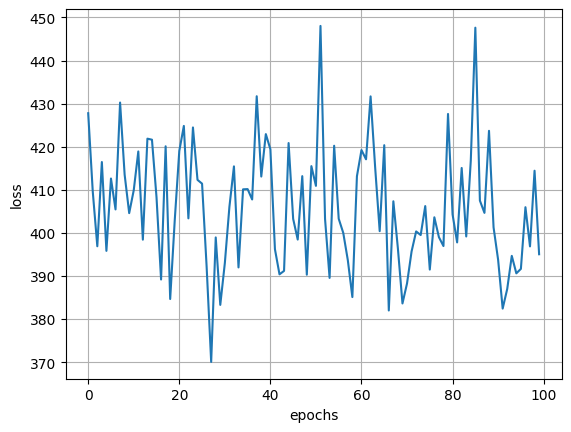

In [13]:
# Use the training dataset to generate the latents to train the ZY MI estimator.

# Only include the semantic components.
zy_dataset = ae.GaussianMixtureDataset(np.array(z_train[:, :sem_dim]), np.array(y_train))

# ml_key = jax.random.PRNGKey(47)
ml_key, init_key = jax.random.split(ml_key)
dm_features = [512, 256]
batch_size = 32

fake_z = jnp.ones((batch_size, sem_dim))
fake_y = jnp.ones((batch_size, 1), dtype=jnp.int32)
fake_time = jnp.ones((batch_size,))

dmodel_ZY_sem = ae.DiffusionLatent(features=dm_features,
                            mapping_size=256,
                            num_labels=10,
                            num_dimensions=sem_dim,
                            beta_min=0.1,
                            beta_max=16,
                            z_embed=False,
                            maxL_prefactor=True, # Note.
                            p_drop=0.1,
                            loss_steps=10)
params_ZY_sem = dmodel_ZY_sem.init(init_key, fake_z, fake_y, fake_time)

params_ZY_sem, losses = ae.train_vae(key=ml_key,
                            model=dmodel_ZY_sem,
                            params=params_ZY_sem,
                            learning_rate=0.001,
                            epochs=100,
                            train_dataset=zy_dataset,
                            batch_size=batch_size
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

train iter:   0%|          | 0/100 [00:00<?, ?it/s]

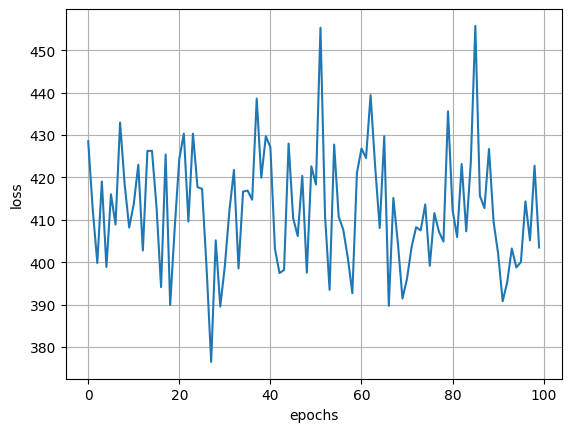

In [14]:
# Use the training dataset to generate the latents to train the ZY MI estimator.

# Only include the *perceptual* components.
zy_dataset = ae.GaussianMixtureDataset(np.array(z_train[:, sem_dim:]), np.array(y_train))

# ml_key = jax.random.PRNGKey(47)
ml_key, init_key = jax.random.split(ml_key)
dm_features = [512, 256]
batch_size = 32

fake_z = jnp.ones((batch_size, sem_dim))
fake_y = jnp.ones((batch_size, 1), dtype=jnp.int32)
fake_time = jnp.ones((batch_size,))

dmodel_ZY_per = ae.DiffusionLatent(features=dm_features,
                            mapping_size=256,
                            num_labels=10,
                            num_dimensions=sem_dim,
                            beta_min=0.1,
                            beta_max=16,
                            z_embed=False,
                            maxL_prefactor=True, # Note.
                            p_drop=0.1,
                            loss_steps=10)
params_ZY_per = dmodel_ZY_per.init(init_key, fake_z, fake_y, fake_time)

params_ZY_per, losses = ae.train_vae(key=ml_key,
                            model=dmodel_ZY_per,
                            params=params_ZY_per,
                            learning_rate=0.001,
                            epochs=100,
                            train_dataset=zy_dataset,
                            batch_size=batch_size
                            )

plt.plot(losses, label='Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)

In [15]:
mi_batch_size = 1000

ent_key, subkey = random.split(ent_key)
mi_sem_y = dmodel_ZY_sem.apply(params_ZY_sem, z_test[:mi_batch_size, :sem_dim], y_test[:mi_batch_size], subkey, method=dmodel_ZY_sem.mutual_info)

ent_key, subkey = random.split(ent_key)
mi_per_y = dmodel_ZY_per.apply(params_ZY_per, z_test[:mi_batch_size, sem_dim:], y_test[:mi_batch_size], subkey, method=dmodel_ZY_per.mutual_info)

print(f'I(Z_sem; Y) = {mi_sem_y}')
print(f'I(Z_per; Y) = {mi_per_y}')

I(Z_sem; Y) = 2.040771961212158
I(Z_per; Y) = 0.24094580113887787
